In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
import itertools as it
import scipy as sp

In [2]:
def count_permutation(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            slice_df[slice_df[slice_df == sort_slice.iloc[j]].first_valid_index()] =  j
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
    return count_p
def entropy(perm:list):
    allperm = sum(perm)
    ent = 0
    for i in range(len(perm)):
        probability = perm[i]/allperm
        if probability !=0:
            ent -= probability * math.log2(probability)
    return ent

In [3]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

In [4]:
def walds_martingale(X, sigma, tetta):
    s = np.random.normal(0, np.sqrt(sigma), X.shape[0])  
    z=np.cumsum(s)
    for i in range(len(z)):
        z[i] = np.exp(tetta * z[i] - 0.5 * tetta**2 *i)
    X.values = z
    return X
def random_walk(X, noise):
    X[0] = 0
    X[1] = X.index[1]
    for i in X[1:]:
        X[i] = X[i-dt.timedelta(1/24)] + np.random.normal(0, noise)
        #X[i] = X[i-dt.timedelta(1/24)] + rd.uniform(-noise, noise)
    return X

In [5]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0

C:\Users\vitya\AppData\Local\Temp\ipykernel_4312\1743055619.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()


In [6]:
sigma = 15
rw = random_walk(datelist.copy(), sigma)

In [7]:
rw.shape

(721,)

In [8]:
rw.tail(15)

2023-07-28 10:00:00   -369.416219
2023-07-28 11:00:00   -368.642376
2023-07-28 12:00:00   -372.557687
2023-07-28 13:00:00   -359.076293
2023-07-28 14:00:00   -365.745265
2023-07-28 15:00:00   -360.682854
2023-07-28 16:00:00   -368.847187
2023-07-28 17:00:00   -362.167358
2023-07-28 18:00:00   -374.059242
2023-07-28 19:00:00   -359.246695
2023-07-28 20:00:00   -368.264905
2023-07-28 21:00:00   -352.791746
2023-07-28 22:00:00   -336.594415
2023-07-28 23:00:00   -338.399569
2023-07-29 00:00:00   -349.587477
dtype: object

In [9]:
rw_train = rw[rw.index < "27/07/2023 15:00:00"]
rw_y = rw[rw.index >= "27/07/2023 15:00:00"]

In [10]:
rw_train.tail(5)

2023-07-27 10:00:00   -378.651101
2023-07-27 11:00:00   -391.193033
2023-07-27 12:00:00   -379.865993
2023-07-27 13:00:00   -387.599524
2023-07-27 14:00:00   -378.003404
dtype: object

In [11]:
pred = rw_y.copy()
for i in range(pred.shape[0]):
    pred[i] = rw_train[-1]

In [12]:
rw_y.head(10)

2023-07-27 15:00:00   -344.245151
2023-07-27 16:00:00   -350.814983
2023-07-27 17:00:00   -359.999132
2023-07-27 18:00:00    -370.35664
2023-07-27 19:00:00   -380.393992
2023-07-27 20:00:00   -372.625561
2023-07-27 21:00:00   -360.072762
2023-07-27 22:00:00   -323.938135
2023-07-27 23:00:00   -328.236379
2023-07-28 00:00:00       -315.69
dtype: object

In [13]:
pred.head(10)

2023-07-27 15:00:00   -378.003404
2023-07-27 16:00:00   -378.003404
2023-07-27 17:00:00   -378.003404
2023-07-27 18:00:00   -378.003404
2023-07-27 19:00:00   -378.003404
2023-07-27 20:00:00   -378.003404
2023-07-27 21:00:00   -378.003404
2023-07-27 22:00:00   -378.003404
2023-07-27 23:00:00   -378.003404
2023-07-28 00:00:00   -378.003404
dtype: object

In [14]:
MSE = mean_squared_error(pred, rw_y)
MSE

1446.9748361738734

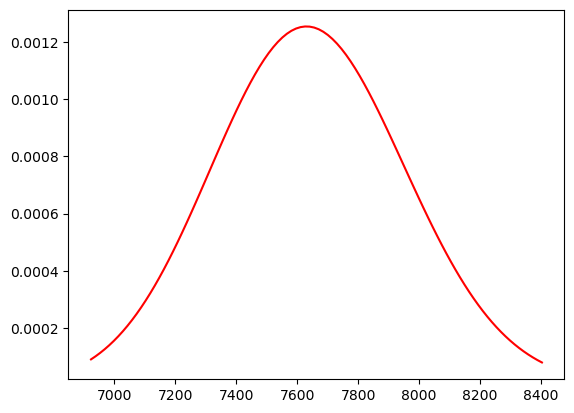

In [15]:
n = pred.shape[0]
a = (n**2-1)/2
beta = (2*sigma**2)/n
x = np.linspace(sp.stats.gamma.ppf(0.01, a, scale= beta),
                sp.stats.gamma.ppf(0.99, a, scale= beta), 100)
pdfGamma = sp.stats.gamma.pdf(x,a,scale=beta)
fig, ax = plt.subplots(1, 1)
ax.plot(x, pdfGamma,
       'r-', label='gamma pdf')
plt.show()

In [118]:
MSE_list = []
sigma = 3
for i in range(10000):
    if i%100 == 0:
        print(i,'/10000')
    rw = random_walk(datelist.copy(), sigma)
    rw_train = rw[rw.index < "28/07/2023 22:00:00"]
    rw_y = rw[rw.index >= "28/07/2023 22:00:00"]
    pred = rw_y.copy()
    for j in range(pred.shape[0]):
        pred[j] = rw_train[-1]
    MSE = mean_squared_error(pred, rw_y)
    MSE_list.append(MSE)

0 /10000
100 /10000
200 /10000
300 /10000
400 /10000
500 /10000
600 /10000
700 /10000
800 /10000
900 /10000
1000 /10000
1100 /10000
1200 /10000
1300 /10000
1400 /10000
1500 /10000
1600 /10000
1700 /10000
1800 /10000
1900 /10000
2000 /10000
2100 /10000
2200 /10000
2300 /10000
2400 /10000
2500 /10000
2600 /10000
2700 /10000
2800 /10000
2900 /10000
3000 /10000
3100 /10000
3200 /10000
3300 /10000
3400 /10000
3500 /10000
3600 /10000
3700 /10000
3800 /10000
3900 /10000
4000 /10000
4100 /10000
4200 /10000
4300 /10000
4400 /10000
4500 /10000
4600 /10000
4700 /10000
4800 /10000
4900 /10000
5000 /10000
5100 /10000
5200 /10000
5300 /10000
5400 /10000
5500 /10000
5600 /10000
5700 /10000
5800 /10000
5900 /10000
6000 /10000
6100 /10000
6200 /10000
6300 /10000
6400 /10000
6500 /10000
6600 /10000
6700 /10000
6800 /10000
6900 /10000
7000 /10000
7100 /10000
7200 /10000
7300 /10000
7400 /10000
7500 /10000
7600 /10000
7700 /10000
7800 /10000
7900 /10000
8000 /10000
8100 /10000
8200 /10000
8300 /10000
8400

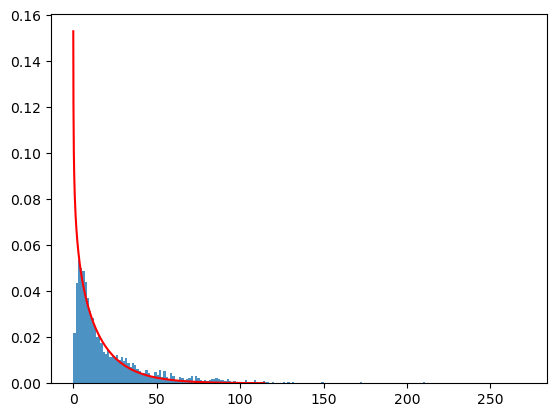

In [145]:
n = pred.shape[0]
a = 0.8
beta = ((2.*sigma**2)/(n/4)) #2sigma^2
x = np.linspace(sp.stats.gamma(a, scale= beta).ppf(0.01),
                sp.stats.gamma(a, scale= beta).ppf(0.999), 1000)
pdfGamma = sp.stats.gamma(a, scale=beta).pdf(x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, pdfGamma,
       'r-', label='gamma pdf')
ax.hist(MSE_list, density=True, bins=200, histtype='stepfilled', alpha=0.8)
plt.show()

In [174]:
MSE_list = []
sigma = 3
for i in range(1000):
    if i%100 == 0:
        print(i,'/1000')
    rw = random_walk(datelist.copy(), sigma)
    rw_train = rw[rw.index < "28/07/2023 23:00:00"]
    rw_y = rw[rw.index >= "28/07/2023 23:00:00"]
    pred = rw_y.copy()
    for j in range(pred.shape[0]):
        pred[j] = rw_train[-1]
    MSE = mean_squared_error(pred, rw_y)
    MSE_list.append(MSE)

0 /1000
100 /1000
200 /1000
300 /1000
400 /1000
500 /1000
600 /1000
700 /1000
800 /1000
900 /1000


2


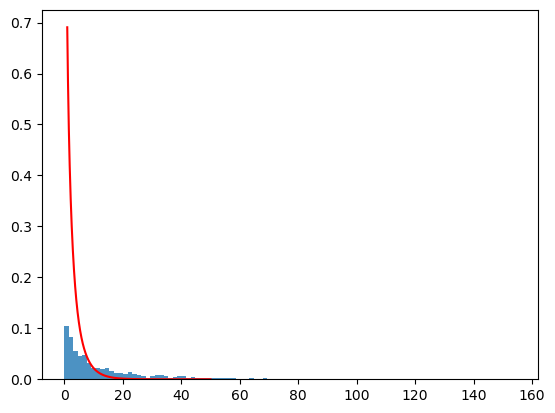

In [182]:
n = pred.shape[0]
print(n)
a = n*(n+1)*(2*n+1)/12
beta = ((2.*sigma**4)/(n)) #2sigma^2
x = np.linspace(1,
                50, 1000)
pdfGamma = 2*sp.stats.gamma(0.5, scale=2*sigma^2).pdf(x)+sp.stats.gamma(0.5, scale=2*sigma^2).pdf(x)+2*sp.stats.norm(0,sigma).pdf(x)*sp.stats.norm(0,sigma).pdf(x)
fig, ax = plt.subplots(1, 1)
ax.plot(x, pdfGamma,
       'r-', label='gamma pdf')
ax.hist(MSE_list, density=True, bins=100, histtype='stepfilled', alpha=0.8)
plt.show()

In [112]:
MSE_list = []
sigma = 3
for i in range(10000):
    if i%100 == 0:
        print(i,'/10000')
    rw = random_walk(datelist.copy(), sigma)
    rw_train = rw[rw.index < "28/07/2023 23:00:00"]
    rw_y = rw[rw.index >= "28/07/2023 23:00:00"]
    pred = rw_y.copy()
    for j in range(pred.shape[0]):
        pred[j] = rw_train[-1]
    MSE = mean_squared_error(pred, rw_y)
    MSE_list.append(MSE)

0 /10000
100 /10000
200 /10000
300 /10000
400 /10000
500 /10000
600 /10000
700 /10000
800 /10000
900 /10000
1000 /10000
1100 /10000
1200 /10000
1300 /10000
1400 /10000
1500 /10000
1600 /10000
1700 /10000
1800 /10000
1900 /10000
2000 /10000
2100 /10000
2200 /10000
2300 /10000
2400 /10000
2500 /10000
2600 /10000
2700 /10000
2800 /10000
2900 /10000
3000 /10000
3100 /10000
3200 /10000
3300 /10000
3400 /10000
3500 /10000
3600 /10000
3700 /10000
3800 /10000
3900 /10000
4000 /10000
4100 /10000
4200 /10000
4300 /10000
4400 /10000
4500 /10000
4600 /10000
4700 /10000
4800 /10000
4900 /10000
5000 /10000
5100 /10000
5200 /10000
5300 /10000
5400 /10000
5500 /10000
5600 /10000
5700 /10000
5800 /10000
5900 /10000
6000 /10000
6100 /10000
6200 /10000
6300 /10000
6400 /10000
6500 /10000
6600 /10000
6700 /10000
6800 /10000
6900 /10000
7000 /10000
7100 /10000
7200 /10000
7300 /10000
7400 /10000
7500 /10000
7600 /10000
7700 /10000
7800 /10000
7900 /10000
8000 /10000
8100 /10000
8200 /10000
8300 /10000
8400

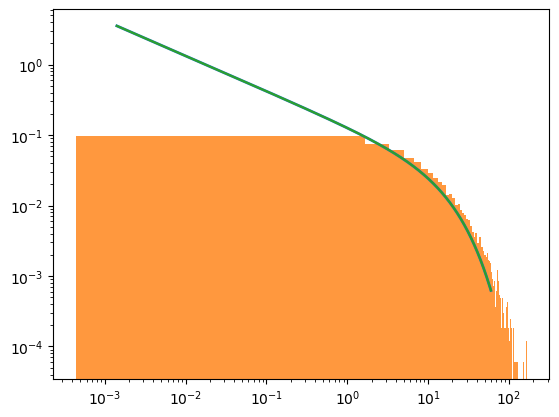

In [117]:
n = pred.shape[0]
x = np.linspace(sp.stats.gamma(a=1./2, scale=2.*sigma**2).ppf(0.01),
                sp.stats.gamma(a=1./2, scale=2.*sigma**2).ppf(0.99), 1000)
pdfchi2 = sp.stats.chi2.pdf(x, 1)
gamma_pdf = sp.stats.gamma(a=1./2, scale=2.*sigma**2).pdf 
fig, ax = plt.subplots(1, 1)
ax.plot(x, gamma_pdf(x), "-", linewidth=2)
ax.hist(MSE_list, density=True, bins=100, histtype='stepfilled', alpha=0.8)
plt.loglog(x, gamma_pdf(x))
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(MSE_list, density=True, bins=200, histtype='stepfilled', alpha=0.8)
plt.show()

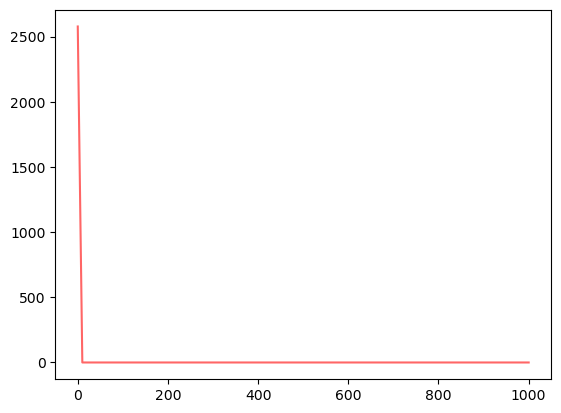

In [60]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, 9**2*pdfchi2,
       'r-', alpha=0.6, label='chi2 pdf')
plt.show()

$f_{MSE}(y) = \dfrac{y^{-1+\dfrac{N}{2}}}{det(A)^{\dfrac{1}{2}}\Gamma(\dfrac{N}{2})} * \Phi_2^N(\dfrac{1}{2},...,\dfrac{1}{2};\dfrac{N}{2};-\dfrac{y}{\lambda_1},...,-\dfrac{y}{\lambda_n})$

$MSE = \dfrac{1}{n} \sum_{j=1}^{n} (\sum_{i=1}^{j} (\xi_i))^2 = \dfrac{1}{n} \sum_{j=1}^{n} \nu_j^2 = \dfrac{1}{n} \sum_{j=1}^{n} Gamma(\dfrac{1}{2}, \dfrac{2}{j\sigma^2})$, где $\nu_j \sim WN(0,j\sigma^2)$

In [48]:
def LaplacePhi2(s, c, x, b):
    P = [1]*len(s)
    for k in range(len(b)):
        for j in range(len(P)):
            P[j] *= ((1 - x[k] * (s[j] ** (-1))) ** (-b[k]))
    y=[]
    for i in range(len(s)):
        y.append(sp.special.gamma(c) * (s[i] ** (-c)) * P[i])
    return y

def Phi2(bvector, c, xvector, N):
    A = 15
    K = np.exp(A / 2)
    alphainv = np.concatenate(([0.5], [1]*(N-1)))
    n = list(range(N))
    y1 = []
    lp2 = LaplacePhi2([(A + 2 * np.pi * 1j * ind) / 2 for ind in n], c, xvector, bvector)
    for i in range(N):
        y1.append((-1)**n[i]*alphainv[i]*lp2[i].real)
    y = K * np.sum(y1)
    return y

In [26]:
# пересчитать определитель и собственные числа
def corGammapdf(y, n, sigma):
    xv = [-y*sigma**2]*(n-1)
    xv.append(-y/(1/sigma**2+n/sigma**2))
    denumerator = ((n+1)/sigma**(2*n))**0.5*sp.special.gamma(n/2)
    numerator = [Phi2([0.5]*n, n*0.5,xv, n)*x**(-1+n/2)/denumerator for x in y]
    return numerator

In [90]:
def ppfSum2 (y, sigma):
    denumerator = (15/(8*sigma**4))**0.5 * sp.special.gamma(2/2)
    numerator = [-Phi2([0.5]*2, 1, [-2*x/(3-(np.sqrt(3))/(np.sqrt(2)*sigma**2)), -2*x/(3+(np.sqrt(3))/(np.sqrt(2)*sigma**2))], 2)/denumerator for x in y]
    return numerator

In [91]:
sigma = 10

In [36]:
MSE_list = []
for i in range(10000):
    if i%100 == 0:
        print(i,'/10000')
    rw = random_walk(datelist.copy(), sigma)
    rw_train = rw[rw.index < "28/07/2023 23:00:00"]
    rw_y = rw[rw.index >= "28/07/2023 23:00:00"]
    pred = rw_y.copy()
    for j in range(pred.shape[0]):
        pred[j] = rw_train[-1]
    MSE = mean_squared_error(pred, rw_y)
    MSE_list.append(MSE)

0 /10000
100 /10000
200 /10000
300 /10000
400 /10000
500 /10000
600 /10000
700 /10000
800 /10000
900 /10000
1000 /10000
1100 /10000
1200 /10000
1300 /10000
1400 /10000
1500 /10000
1600 /10000
1700 /10000
1800 /10000
1900 /10000
2000 /10000
2100 /10000
2200 /10000
2300 /10000
2400 /10000
2500 /10000
2600 /10000
2700 /10000
2800 /10000
2900 /10000
3000 /10000
3100 /10000
3200 /10000
3300 /10000
3400 /10000
3500 /10000
3600 /10000
3700 /10000
3800 /10000
3900 /10000
4000 /10000
4100 /10000
4200 /10000
4300 /10000
4400 /10000
4500 /10000
4600 /10000
4700 /10000
4800 /10000
4900 /10000
5000 /10000
5100 /10000
5200 /10000
5300 /10000
5400 /10000
5500 /10000
5600 /10000
5700 /10000
5800 /10000
5900 /10000
6000 /10000
6100 /10000
6200 /10000
6300 /10000
6400 /10000
6500 /10000
6600 /10000
6700 /10000
6800 /10000
6900 /10000
7000 /10000
7100 /10000
7200 /10000
7300 /10000
7400 /10000
7500 /10000
7600 /10000
7700 /10000
7800 /10000
7900 /10000
8000 /10000
8100 /10000
8200 /10000
8300 /10000
8400

In [37]:
n = pred.shape[0]
n

2

In [28]:
ppfSum2(x, sigma)

[84.53077348669426,
 57.78714536305866,
 41.42697441593171,
 31.996853725663165,
 25.990797791826434,
 21.857657937046483,
 18.84789857522636,
 16.561493096035125,
 14.767037067178302,
 13.321856224333107,
 12.133376668507632,
 11.138982632408704,
 10.294838699921813,
 9.569356483849464,
 8.939205413780083,
 8.386784561057802,
 7.898568196456572,
 7.463992504180857,
 7.074687889564172,
 6.723938022097765,
 6.406291234639161,
 6.117276509251773,
 5.853192648341038,
 5.610949552765616,
 5.387947187383067,
 5.181982198323569,
 4.991175086604205,
 4.81391284867308,
 4.648803384566482,
 4.4946389516324405,
 4.350366638024836,
 4.2150643323692405,
 4.087921032410003,
 3.968220605656197,
 3.8553283163101137,
 3.7486795840848974,
 3.6477705552934045,
 3.5521501543673435,
 3.4614133516182193,
 3.375195435577836,
 3.2931671193215646,
 3.2150303424942677,
 3.140514656349489,
 3.069374099496866,
 3.0013844883815417,
 2.9363410596694868,
 2.8740564123569854,
 2.81435870608037,
 2.7570900791772885,


In [69]:
MSE_list

[68.9162835691984,
 68.31270645434837,
 32.17118638741479,
 386.6997810370247,
 307.535295815874,
 234.69888654640118,
 483.5442392249435,
 387.72161701490904,
 76.75607050062779,
 237.17532245282564,
 35.891027550250186,
 54.48228325367923,
 25.248320713857698,
 383.3817548737119,
 1108.961791998941,
 211.8980831398506,
 24.65903013497166,
 299.41097634687367,
 90.30989428974578,
 168.5832510502432,
 117.78176338750268,
 130.82504314588064,
 68.01332421413291,
 118.06489238491213,
 210.08427744354623,
 251.90868463478535,
 222.75001670179103,
 104.49275739078388,
 38.43150605233404,
 67.70054641167762,
 41.53945457882466,
 64.48879888448752,
 134.08367332494063,
 123.90167487982914,
 56.78310570011082,
 17.21258455868064,
 688.6659603810749,
 119.150067657948,
 125.87293650657233,
 239.9173895807898,
 48.51819203161817,
 8.540899084946169,
 13.22217222945169,
 58.14027513013656,
 100.7442555397741,
 140.58923268826663,
 25.673610398780795,
 29.210903381894333,
 127.40251022929175,
 18

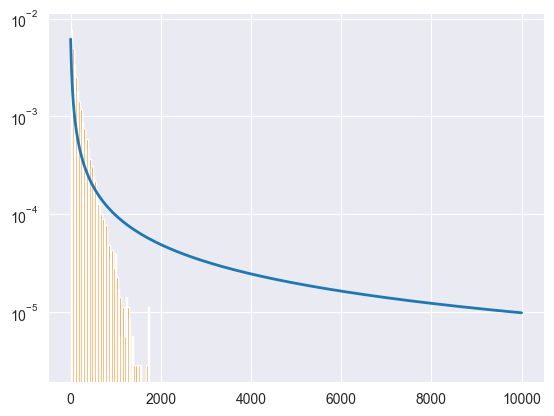

In [99]:

x = np.linspace(0.1,
                10000, 1000)

fig, ax = plt.subplots(1, 1)
ax.plot(x, [al/1000000 for al in ppfSum2(x, sigma)], "-", linewidth = 2)
ax.hist(MSE_list, density = True, bins=50, alpha=1)
#plt.loglog(x, ppfSum2(x, sigma))
plt.semilogy()
plt.show()

In [22]:
corGammapdf(x,n,sigma)

[4.47213595499958,
 4477.054902017589,
 8949.637668080179,
 13422.220434142768,
 17894.80320020536,
 22367.38596626795,
 26839.96873233054,
 31312.55149839313,
 35785.134264455715,
 40257.7170305183,
 44730.29979658089,
 49202.882562643485,
 53675.46532870607,
 58148.04809476867,
 62620.63086083126,
 67093.21362689385,
 71565.79639295644,
 76038.37915901904,
 80510.96192508162,
 84983.54469114421,
 89456.12745720679,
 93928.71022326939,
 98401.29298933198,
 102873.87575539456,
 107346.45852145716,
 111819.04128751975,
 116291.62405358233,
 120764.20681964494,
 125236.78958570753,
 129709.37235177011,
 134181.9551178327,
 138654.53788389527,
 143127.12064995785,
 147599.70341602046,
 152072.28618208304,
 156544.86894814562,
 161017.4517142082,
 165490.0344802708,
 169962.61724633342,
 174435.200012396,
 178907.78277845855,
 183380.36554452116,
 187852.94831058377,
 192325.53107664635,
 196798.11384270896,
 201270.69660877154,
 205743.27937483412,
 210215.8621408967,
 214688.4449069593,


In [17]:
x

array([1.00000e-03, 1.00200e+00, 2.00300e+00, 3.00400e+00, 4.00500e+00,
       5.00600e+00, 6.00700e+00, 7.00800e+00, 8.00900e+00, 9.01000e+00,
       1.00110e+01, 1.10120e+01, 1.20130e+01, 1.30140e+01, 1.40150e+01,
       1.50160e+01, 1.60170e+01, 1.70180e+01, 1.80190e+01, 1.90200e+01,
       2.00210e+01, 2.10220e+01, 2.20230e+01, 2.30240e+01, 2.40250e+01,
       2.50260e+01, 2.60270e+01, 2.70280e+01, 2.80290e+01, 2.90300e+01,
       3.00310e+01, 3.10320e+01, 3.20330e+01, 3.30340e+01, 3.40350e+01,
       3.50360e+01, 3.60370e+01, 3.70380e+01, 3.80390e+01, 3.90400e+01,
       4.00410e+01, 4.10420e+01, 4.20430e+01, 4.30440e+01, 4.40450e+01,
       4.50460e+01, 4.60470e+01, 4.70480e+01, 4.80490e+01, 4.90500e+01,
       5.00510e+01, 5.10520e+01, 5.20530e+01, 5.30540e+01, 5.40550e+01,
       5.50560e+01, 5.60570e+01, 5.70580e+01, 5.80590e+01, 5.90600e+01,
       6.00610e+01, 6.10620e+01, 6.20630e+01, 6.30640e+01, 6.40650e+01,
       6.50660e+01, 6.60670e+01, 6.70680e+01, 6.80690e+01, 6.907